# Derive Strain Rates from ITS_LIVE Velocity Data

This notebook will walk through how to calculate strain rates from the cloud hosted ITS_LIVE velocity data, which we learned how to access in the previous notebook

## Load in Packages

In [1]:
import geopandas as gpd
import numpy as np
import xarray as xr
import rioxarray as rxr

from shapely.geometry import Polygon
from shapely.geometry import Point
import matplotlib.pyplot as plt

import json
import blue_ice_tools as bit
import itslivetools

## Load in Shapefile and Velocity Data

As shown at the end of the previous notebook, we can use `bit.get_data_cube` with the Shirase Glacier shapefile to get the ITS_LIVE velocities over this area

In [2]:
# Load in shapefile of Shirase Glacier
shirase_shape = gpd.read_file('../data/shirase-glacier/shirase.shp')

# Load in ITS_LIVE velocities for shapefile
shirase_dc = bit.get_data_cube(shape=shirase_shape).compute()
shirase_dc

KeyboardInterrupt: 

## Strain Rate Tensor

To calculate the strain rate tensor, we can take the gradient of velocity [source?] as follows:
$$
\dot{\epsilon} =  \begin{bmatrix}
                    \dot{\epsilon_{xx}} & \dot{\epsilon_{xy}} \\
                    \dot{\epsilon_{yx}} & \dot{\epsilon_{yy}}
                  \end{bmatrix}
               = 
                  \begin{bmatrix}
                    \frac{\partial u}{\partial x} & \frac{1}{2} \left( \frac{\partial v}{\partial x} + \frac{\partial u}{\partial y} \right) \\
                    \frac{1}{2} \left( \frac{\partial v}{\partial x} + \frac{\partial u}{\partial y} \right) & \frac{\partial v}{\partial y}
                  \end{bmatrix}
$$

We can do this with two methods using python. The first method uses `np.gradient`, and is compatible with xarray, but not dask. This requires the dataset to be computed to memory sooner than necessary. <br>
The second method uses `xr.DataArray.differentiate`, an xarray native function that computes derivatives with the coordinates and is dask compatible

In [3]:
# Save vx and vy as variables, u=vx, v=vy
vx = shirase_dc.vx
vy = shirase_dc.vy

# Calculate the partial derivatives for each variable in each direction
du_dx = vx.differentiate('x')
du_dy = vx.differentiate('y')
dv_dx = vy.differentiate('x')
dv_dy = vy.differentiate('y')

# Assign to strain rate tensor variables
eps_xx = du_dx
eps_yy = dv_dy
eps_xy = .5 * (du_dy + dv_dx)

After rotating the strain rates along flow, we can calculate the effective strain rate following Cuffey & Patterson 2010
$$
\dot{\epsilon}_{E} &= \sqrt{\frac{1}{2} \left[\dot{\epsilon}_{\text{xx}}^2 + \dot{\epsilon}_{\text{yy}}^2 \right] + \dot{\epsilon}_{\text{xy}}^2} 
$$
The effective strain rate is a essentially the magnitude of the strain rate tensor, also called the second invariant.

In [4]:
e_eff = np.sqrt(0.5 * (eps_xx ** 2 + eps_yy ** 2) + eps_xy ** 2)

Since the xarray differentiate function is compatible with dask, the previous cell was only lazily computed, and has not actually been calculated by the computer, only been added to the dask task list. This makes it extremely memory efficient. 

Let's take a look at the strain rates we just calculated.

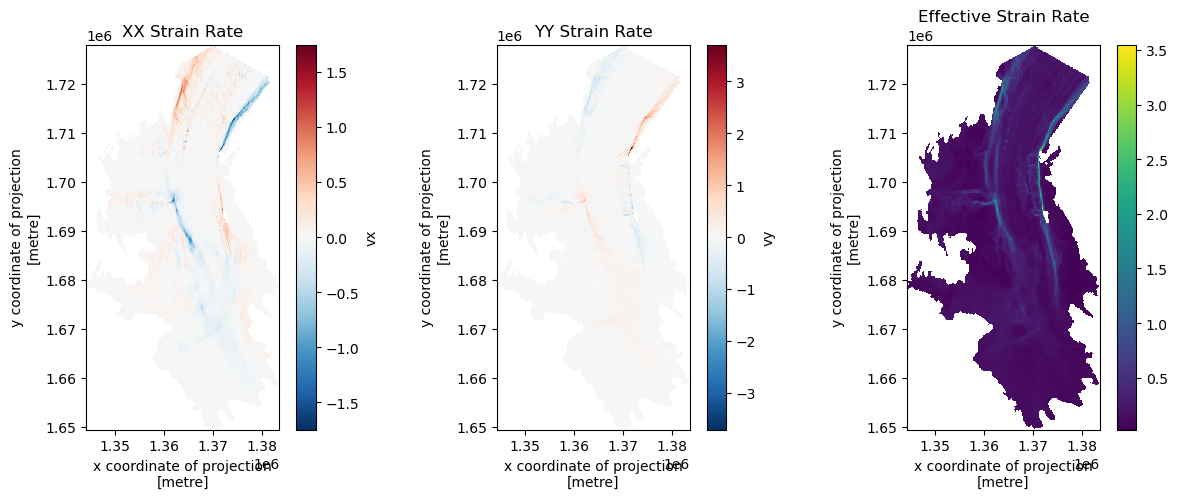

In [5]:
# create a figure with 3 columns
fig, axs = plt.subplots(ncols=3, figsize=(15,5))

# plot the temporal average of longitunal strain rates on col 1
eps_xx.mean(dim='mid_date').plot(ax=axs[0])
axs[0].set_title('XX Strain Rate')

# plot the temporal average of transverse strain rates on col 2
eps_yy.mean(dim='mid_date').plot(ax=axs[1])
axs[1].set_title('YY Strain Rate')

# plot the temporal average of effective strain rates on col 3
e_eff.mean(dim='mid_date').plot(ax=axs[2])
axs[2].set_title('Effective Strain Rate')

# set the x/y aspect to equal on each column
for ax in axs:
    ax.set_aspect('equal')

plt.show()

## Rotated Strain Rates

These maps look good, but they're a little bit simplified. The x- and y- directions here are along with the graph coordinates. The next step is to rotate the strain rates to match the direction of ice flow. The method here follows Alley et al (2018),
$$
\begin{aligned}
\dot{\epsilon}_{\text{lon}} &= \dot{\epsilon}_x \cos^2 \alpha + 2 \dot{\epsilon}_{xy} \cos \alpha \sin \alpha + \dot{\epsilon}_y \sin^2 \alpha \\
\dot{\epsilon}_{\text{trans}} &= \dot{\epsilon}_x \sin^2 \alpha - 2 \dot{\epsilon}_{xy} \cos \alpha \sin \alpha + \dot{\epsilon}_y \cos^2 \alpha \\
\dot{\epsilon}_{\text{shear}} &= (\dot{\epsilon}_y - \dot{\epsilon}_x) \cos \alpha \sin \alpha + \dot{\epsilon}_{xy} \left(\cos^2 \alpha - \sin^2 \alpha \right)
\end{aligned}
$$

Where the angle, $\alpha$ is given by $\arctan\left(\frac{v}{u}\right)$. The angle here is computed using `np.arctan2`, which is compatible with dask. The rest of the equations are computed using `np.cos` and `np.sin` operators

In [6]:
alpha = np.arctan2(vy, vx)

eps_lon = (
    (eps_xx * (np.cos(alpha) ** 2)) + 
    (2 * eps_xy * np.cos(alpha) * np.sin(alpha)) + 
    (eps_yy * (np.sin(alpha) ** 2))
)
eps_trn = (
    (eps_xx * (np.sin(alpha) ** 2)) - 
    (2 * eps_xy * np.cos(alpha) * np.sin(alpha)) + 
    (eps_yy * (np.cos(alpha) ** 2))
)
eps_shr = (
    (eps_yy - eps_xx) * np.cos(alpha) * np.sin(alpha) + 
    eps_xy * ((np.cos(alpha) ** 2) - (np.sin(alpha) ** 2))
)

We can now and plot the values of longitudinal, transverse, and effective strain rate to get an idea of what these values look like after rotation compared to their unrotated counterparts. <br>
This cell will take a very long time to run because all of the calculations from previous cells must be computed to display the figure.

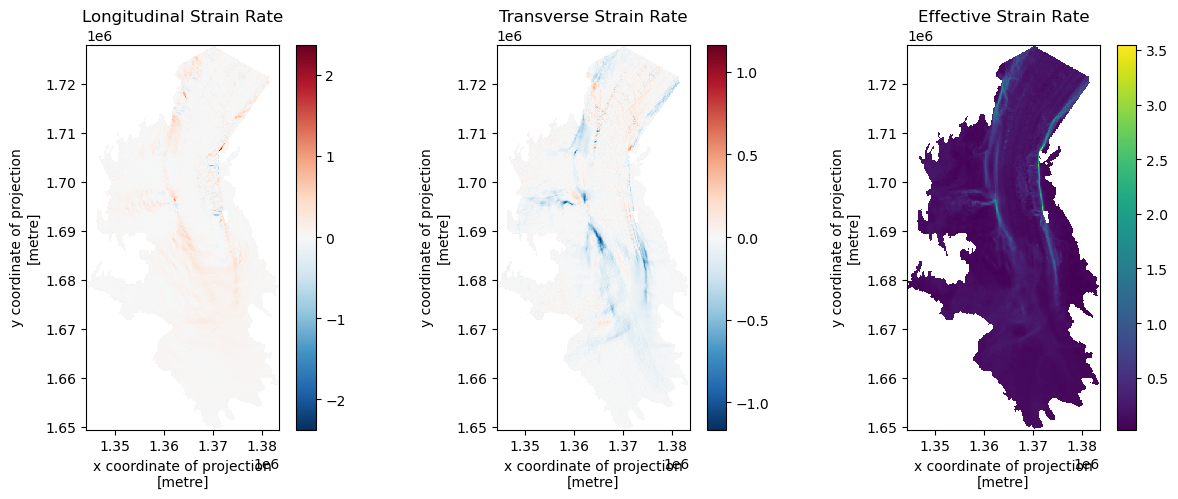

In [7]:
# create a figure with 3 columns
fig, axs = plt.subplots(ncols=3, figsize=(15,5))

# plot the temporal average of longitunal strain rates on col 1
eps_lon.mean(dim='mid_date').plot(ax=axs[0])
axs[0].set_title('Longitudinal Strain Rate')

# plot the temporal average of transverse strain rates on col 2
eps_trn.mean(dim='mid_date').plot(ax=axs[1])
axs[1].set_title('Transverse Strain Rate')

# plot the temporal average of effective strain rates on col 3
e_eff.mean(dim='mid_date').plot(ax=axs[2])
axs[2].set_title('Effective Strain Rate')

# set the x/y aspect to equal on each column
for ax in axs:
    ax.set_aspect('equal')

plt.show()

## Glen's Flow Law and Principle Stresses

Now that we have derived the strain rates, we can use Glen's Flow law to convert from the strain rate tensor to the stress tensor. Glen's Flow Law defines the conversion as:
$$
\tau_{jk} = A^{-\left[ 1 / n \right]}\; \dot{\epsilon}_{E}^{\;\left[\left(1-n\right)/n\right]}\; \epsilon_{jk}
$$
Following guidelines from Cuffey & Patterson 2010, we set $A = 3.5\times10^{-25}$

In [8]:
n=3
exp = ((1 - n) / n)
A = 3.5e-25 * (365 * 24 * 3600)    # Units converter from 1/yr to 1/s

tau_xx = (A ** (-1 / n)) * (e_eff ** exp) * eps_lon
tau_yy = (A ** (-1 / n)) * (e_eff ** exp) * eps_trn

Glen's Flow law allowed us to calculate the deviatoric stress tensor. We can use the following reation to convert to the principle stress tensor: 
$$
\sigma_1 = 2 \tau_1 + \tau_2 \\
\sigma_2 = \tau_1 + 2 \tau_2
$$

The principle stresses are then used to compute the Von Mises Stress, where:
$$
\sigma_{vm} = \sqrt{\sigma_{1}^2 + \sigma_{2}^2 - \sigma_1\sigma_2}
$$
Von Mises Stress can be interpreted as the yield stress under certain failure criterion

In [9]:
# Convert from tau to sigma, principle stresses
# Divide by 1000 to conver to kPa
sigma1 = ((2 * tau_xx) + tau_yy) / 1000
sigma2 = (tau_xx + (2 * tau_yy)) / 1000

# Compute Von Mises Stress following Vaughan et al
sigma_vm = np.sqrt((sigma1 ** 2) + (sigma2 ** 2) - (sigma1 * sigma2))

We can now plot and visualize how the Principle and Deviatoric stresses compare. We will plot the temporal mean of each for right now. <br>
This cell will also take a significant amount of time to compute

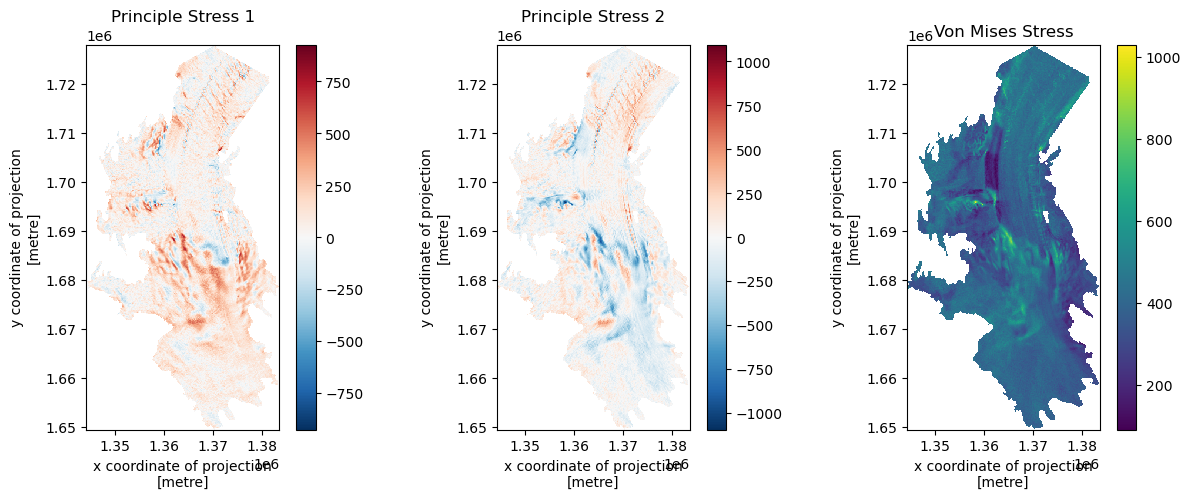

In [10]:
# Create a figure with 3 columns
fig, axs = plt.subplots(ncols=3, figsize=(15,5))

# plot temporal avg of P1 on column 1
sigma1.mean(dim='mid_date').plot(ax=axs[0])
axs[0].set_title('Principle Stress 1')

# plot temporal avg of P2 on column 2
sigma2.mean(dim='mid_date').plot(ax=axs[1])
axs[1].set_title('Principle Stress 2')

# plot temporal avg of VM stress on column 3
sigma_vm.mean(dim='mid_date').plot(ax=axs[2])
axs[2].set_title('Von Mises Stress')

# set x/y aspect to equal
for ax in axs:
    ax.set_aspect('equal')

plt.show()

## Strain Rate and Stress Function

Luckily, this process doesn't need to be written out every single time you want to derive a strain rate and subsequent stress. I have written a function `bit.compute_strain_stress` that will compute it all for you, detecting the type of array passed and computing the gradient with the appropriate method.

In [11]:
bit.compute_strain_stress?

Signature:
bit.compute_strain_stress(
    vx: xarray.core.dataarray.DataArray | numpy.ndarray,
    vy: xarray.core.dataarray.DataArray | numpy.ndarray,
    dx: int = 120,
    dy: int = 120,
    axis: tuple = (1, 2),
    rotate: bool = False,
) -> xarray.core.dataarray.DataArray | numpy.ndarray
Docstring:
Calculate the strain rate and Von Mises stress of the given velocities. 

Parameters:
-----------
vx (xr.DataArray | np.ndarray):
    velocity in the x-direction
vy (xr.DataArray | np.ndarray):
    velocity in the y-direction
dx (int, optional):
    pixel length in m. Only needs to be passed if using numpy
    Default to 120m
dy (int, optional):
    pixel length in m. Only needs to be passed if using numpy
    Default to 120m
axis (tuple, optional):
    specifies the axis to take the gradient on. Defaults to (1,2), meaning (x, y)
rotate (bool, optional):
    rotate the strain rate components to along flow, accross flow, and shear. Default to False

Returns:
--------
xr.DataArray | np.n

The parameters for this function are the x and y velocities. If `vx` and `vy` are xarray DataArrays, these are the only required parameters. If you would like to rotate the strain rates, you can pass `rotated=True`. 

If `vx` and `vy` are numpy arrays, make sure to pass the proper parameters for dx, dy, and axis. The parameters are currently set up to run that if `vx = ds.vx.values` were passed from ITS_LIVE data, there would need to be no changes. `dx = dy = 120` is the distance step of ITS_LIVE data, `axis=(1,2)` is so that the axis for the gradient are on the x and y, not over the time axis. Adjust as needed if making changes to the data structure.

This function is designed to work best with a (time, y, x) dimension structure, such as the ITS_LIVE data. Passing xarray DataArrays works best because the function automatically accounts for the change in the coordinate, and does not need a dx/dy to be specified.

The function returns a list of DataArrays, (eps_eff, eps_xx, eps_yy, sigma_vm, sigma1, sigma2), in that order.

In [12]:
vars = ['eps_eff', 'eps_xx', 'eps_yy', 'sigma_vm', 'sigma1', 'sigma2']
shirase_dc[vars] = bit.compute_strain_stress(shirase_dc.vx, shirase_dc.vy, rotate=True)